# Example_8_1

In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/jdariasl/OTBD/main/content/init.py
import init; init.init(force_download=False)

In [1]:
from local.lib.Generation import scenarios_regression
import cvxpy as cp
from local.lib.utils import solver_cvx, grad_FOM, grad_SOM, bcd_ridge, eval_loss, make_graph, ridge_tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
%load_ext tensorboard

2023-10-19 10:29:08.860471: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Let us assume the general problem in the most general formulation
form
$$\min_{{\bf{x}}} \frac{1}{n}\left\Vert {\bf{A}}{\bf{x}}-{\bf{b}}\right\Vert _{2}^{2}+\frac{\lambda}{2}\left\Vert {\bf{x}}\right\Vert _{2}^{2}$$

Solve it using symbolic computation and plot the **computational graph**.

In [2]:
# Loading scenarios
# ===========================
scenario=4
data_reg, set_up=scenarios_regression(scenario);

# Definition of the problem
#===================================
loss_fn = lambda n, X, Y, w: (1/n)*cp.pnorm(X @ w - Y, p=2)**2
reg_L2 = lambda w: cp.pnorm(w, p=2)**2

loss_LS_L2 = lambda n, X, Y, w, lambd: loss_fn(n, X, Y, w) + (lambd/2) * reg_L2(w)
grad_LS_L2 = lambda n, X, Y, w, lambd: (2/n)*X.T@(X @ w - Y) + lambd * w
Hess_LS_L2 = lambda n, X, Y, w, lambd: (2/n)*X.T@X + lambd * np.eye(X.shape[1])



# Different ways to solve theoreticaly the LS
#=========================================
# Solution of the empirical risk using CVX

w_L2_cvx=solver_cvx(set_up,loss_LS_L2);

Xtrain = set_up['Xtrain'][:,:set_up['d']+1]
w_opt=np.linalg.inv(2/set_up['Niter_train']*Xtrain.T@Xtrain + set_up['Lambda']*np.eye(set_up['d']+1))@((2/set_up['Niter_train'])*Xtrain.T)@set_up['ytrain'][:,0];

w = cp.Variable(w_L2_cvx.shape[0])
w.value = w_L2_cvx
loss_opt=loss_LS_L2(set_up['Niter_train'],set_up['Xtrain'][:,0:set_up['d']+1],set_up['ytrain'][:,0],w_L2_cvx,set_up['Lambda']).value
print(w_L2_cvx, w_opt)

          
# Gradient descent
out_gd = grad_FOM(set_up,grad_LS_L2)
loss_grad=eval_loss(out_gd,set_up,loss_LS_L2)

# Newton algorithm
out_hess =grad_SOM(set_up,grad_LS_L2,Hess_LS_L2)
loss_hess=eval_loss(out_hess,set_up,loss_LS_L2)

#TF symbolic computation
@tf.function
def loss_LS_L2_TF(Xtrain, Ytrain, w, lamb): 
    return tf.reduce_mean(tf.square((tf.matmul(Xtrain,w)-Ytrain))) + (lamb/2)*tf.square(tf.norm(w))

out_tf = ridge_tf(set_up,loss_LS_L2_TF)
loss_tf=eval_loss(out_tf.T,set_up,loss_LS_L2)

[ 0.16023644  0.12285387  0.89986317  0.18954107  0.42294006 -0.32553393
  0.20695549  0.13894403  0.03981359 -0.68473685  0.30388745  0.53416152] [ 0.16025958  0.12295171  0.89957929  0.18967444  0.42282234 -0.32539201
  0.20685134  0.13900141  0.03980838 -0.68462043  0.30373045  0.53409645]


## Let's plot the computational graph

In [5]:
!rm -rf logs
w = tf.Variable(initial_value=np.array(set_up["Initial"]).reshape(-1,1), dtype=tf.float32)
Xtrain = set_up['Xtrain'][:,:set_up['d']+1]
Xtrain =  Xtrain.astype(np.float32)
Ytrain = np.array(set_up['ytrain'][:,0]).reshape(-1,1).astype(np.float32)
lamb = set_up["Lambda"]
make_graph(loss_LS_L2_TF, Xtrain,Ytrain,w,lamb, logdir="logs")

In [6]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 47595), started 16:10:07 ago. (Use '!kill 47595' to kill it.)

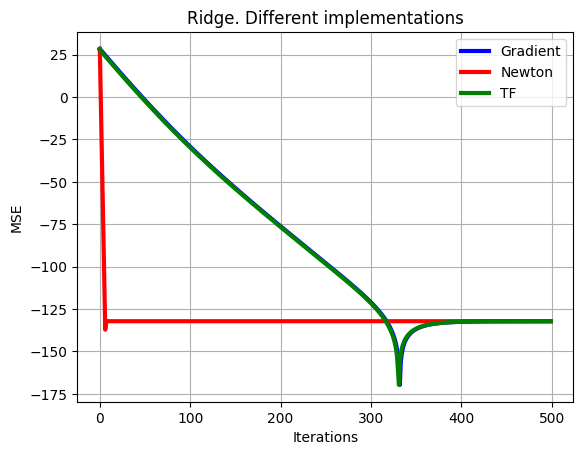

In [7]:
# Plot of learning curves
plt.plot(np.arange(0,set_up['Niter_train']),10*np.log10(np.sum((loss_grad-loss_opt*np.ones((1,set_up['Niter_train'])))**2,axis=0)),color='b', linewidth = 3)
plt.plot(np.arange(0,set_up['Niter_train']),10*np.log10(np.sum((loss_hess-loss_opt*np.ones((1,set_up['Niter_train'])))**2,axis=0)),color='r', linewidth = 3)
plt.plot(np.arange(0,set_up['Niter_train']),10*np.log10(np.sum((loss_tf-loss_opt*np.ones((1,set_up['Niter_train'])))**2,axis=0)),color='g', linewidth = 3),
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.grid()
plt.legend(['Gradient','Newton','TF'])
plt.title('Ridge. Different implementations')
plt.show()